In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.linalg import inv

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

# Q4 - A first Gibbs sampler

## Point 1

In [3]:
# Sample from distribution p(s1,s2|t,y) 
def sample_s(x_b, mu_a, A, b, sigma_a, sigma_ba):
    
    # Calculate Sigma_{a|b}
    sigma_ab = inv(inv(sigma_a) + A.T@inv(sigma_ba)@A)
    
    # Calculate mu_{a|b}
    mu_ab = sigma_ab@(inv(sigma_a)@mu_a + A.T@inv(sigma_ba)@(x_b-b))
    
    # Return N(mu_{a|b}, Sigma_{a|b})
    return multivariate_normal.rvs(mu_ab.reshape(-1), sigma_ab)

# Sample from distribution p(t|s1,s2,y). 
def sample_t(y, s1, s2, sigma_ba):
    
    mean = s1 - s2
    
    # Do moment-matching
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0
    
    # Scale a, b
    a_scaled, b_scaled = (a - mean) / np.sqrt(sigma_ba), (b - mean) / np.sqrt(sigma_ba)
    
    # Return truncated norm (result from Q3 - 2)
    return truncnorm.rvs(a_scaled, b_scaled, mean, sigma_ba)

# Gibbs sampler
def gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init):
    s1_samples = np.zeros(n_samples)
    s2_samples = np.zeros(n_samples)
    s1_samples[0] = s_init[0]
    s2_samples[0] = s_init[1]
    for i in range(1, n_samples):
        t = sample_t(y, s1_samples[i-1], s2_samples[i-1], sigma_ba)
        s1_samples[i], s2_samples[i] = sample_s(t, mu_a, A, b, sigma_a, sigma_ba)
    return s1_samples[burn:], s2_samples[burn:]

In [4]:
# Set values
mu_a = np.array([[0, 0]]).T
A = np.array([[1,-1]])
b = np.array([[0]])
sigma_a = np.array([[1,0],[0,1]])
sigma_ba = np.array([[1]])
y = 1

### First run

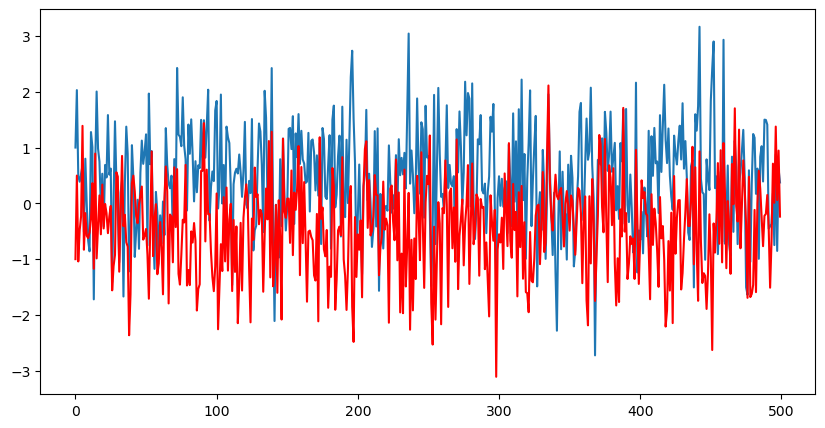

0.46279497027994193
-0.4588768232093607


In [5]:
n_samples = 500
s_init = [1,-1]
burn = 0
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)
plt.plot(s1)
plt.plot(s2, color='red')
plt.show()

print(np.mean(s1))
print(np.mean(s2))

### Analyze burn-in

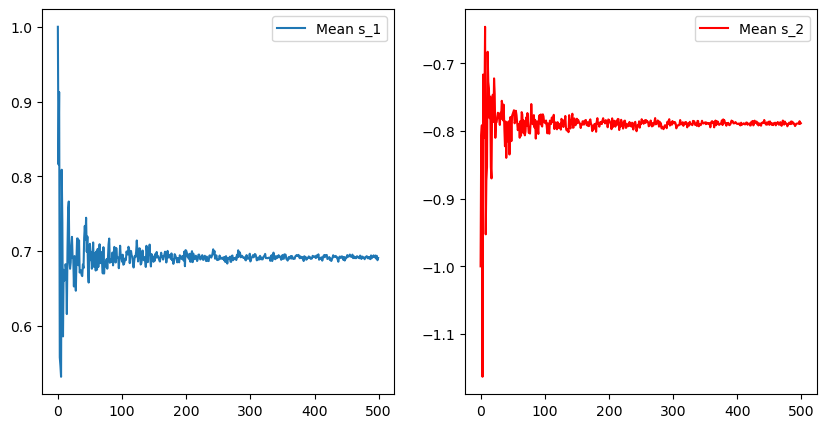

In [6]:
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)

def getMeans(samples):
    for i in range(0, len(samples)):
        samples[i] = np.sum(samples[:i+1])/(i+1)
    return samples

means_s1 = getMeans(s1)
means_s2 = getMeans(s2)

plt.figure(1)
plt.subplot(1, 2, 1)
plt.plot(means_s1,label="Mean s_1")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(means_s2,label="Mean s_2", color='red')
plt.legend()
plt.show()

### Conclusion: choose burn in ~100

### Second run

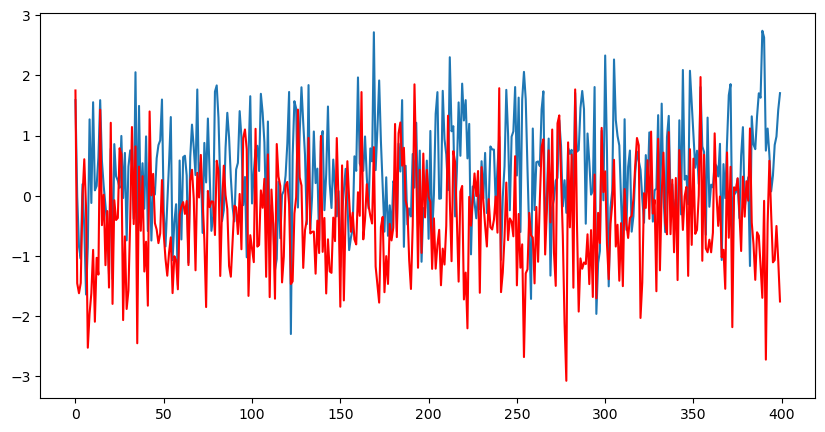

0.4044709500966676
-0.4156875945499807


In [7]:
burn = 100
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)
plt.plot(s1)
plt.plot(s2, color='red')
plt.show()

print(np.mean(s1))
print(np.mean(s2))

## Point 2

In [8]:
# Take samples from gibbs sampler and transform into gaussian distributions
def gauss_transform(samples, xs):
    s_mean = np.mean(samples)
    s_cov = np.cov(samples)
    gaussian = multivariate_normal.pdf(xs, s_mean, s_cov, n_samples)
    return gaussian

## Point 3 & 4

In [9]:
from time import time

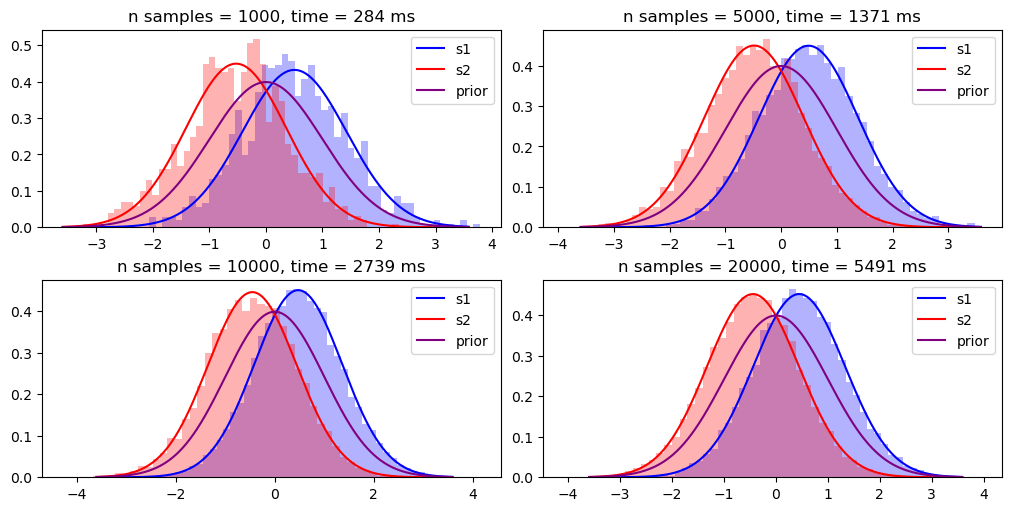

In [10]:
plt.rcParams['figure.constrained_layout.use'] = True

def point3(n, t0, xs):
    s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n, burn, s_init)
    s1_gauss = gauss_transform(s1, xs)
    s2_gauss = gauss_transform(s2, xs)
    t = int((time() - t0)*1000)
    prior = multivariate_normal.pdf(xs, 0, 1, n)
    plt.hist(s1, bins=50, density=True, color='blue', alpha=0.3)
    plt.hist(s2, bins=50, density=True, color='red', alpha=0.3)
    plt.plot(xs, s1_gauss, label='s1', color='blue')
    plt.plot(xs, s2_gauss, label='s2', color='red')
    plt.plot(xs, prior, label='prior', color='purple')
    plt.legend()
    plt.title(f'n samples = {str(n)}, time = {str(t)} ms')


# First run, n = 500
t0 = time()
n_samples = 1000
xs = np.linspace(np.mean(s1)-4, np.mean(s2)+4, n_samples)
plt.subplot(2,2,1)
point3(n_samples, t0, xs)

# Second run, n = 1000
t0 = time()
n_samples = 5000
plt.subplot(2,2,2)
point3(n_samples, t0, xs)

# Third run, n = 1500
t0 = time()
n_samples = 10000
plt.subplot(2,2,3)
point3(n_samples, t0, xs)

# Fourth run, n = 2000
t0 = time()
n_samples = 20000
plt.subplot(2,2,4)
point3(n_samples, t0, xs)


plt.show()